In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
! pip install -q kaggle

In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt
from warnings import filterwarnings

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, BatchNormalization,MaxPooling2D
from keras import models
from tensorflow.keras import layers
import os
import os.path
from pathlib import Path
import cv2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.utils.np_utils import to_categorical
from sklearn.model_selection import train_test_split
from keras import regularizers
from tensorflow.keras.optimizers import RMSprop,Adam
import glob
from PIL import Image
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.applications import VGG19, InceptionV3, ResNet50
from tensorflow.keras.models import Model

from keras.applications.inception_v3 import InceptionV3
from sklearn.metrics import confusion_matrix

In [ ]:
!mkdir '/content/drive/MyDrive/dandelionimagesdataset'

mkdir: cannot create directory ‘/content/drive//MyDrive/dandelionimagesdataset’: File exists


In [ ]:
os.environ['KAGGLE_USERNAME'] = "preetichouhan"
os.environ['KAGGLE_KEY'] = "7ee024a6d611b0c8def5fd94c18e869e"
!kaggle datasets download -d coloradokb/dandelionimages --force

100% 3.52G/3.53G [01:35<00:00, 26.1MB/s]
100% 3.53G/3.53G [01:35<00:00, 39.8MB/s]


In [ ]:
!pip install pyunpack

In [ ]:
from pyunpack import Archive
Archive('/content/dandelionimages.zip').extractall('/content/drive//MyDrive/dandelionimagesdataset')

In [4]:
sdir=r'/content/drive/MyDrive/dandelionimagesdataset/Images'
slist=os.listdir(sdir)

classes=[]
filepaths=[]
labels=[]

for d in slist:
    dpath=os.path.join(sdir, d)
    if os.path.isdir(dpath):
        classes.append(d)

class_count=len(classes)

for klass in classes:   
    classpath=os.path.join(sdir,klass)
    filelist=os.listdir(classpath)    
    for f in filelist:
        fpath=os.path.join(classpath, f)
        filepaths.append(fpath)
        labels.append(klass)


print ('number of files: ', len(filepaths), '   number of labels: ', len(labels))


number of files:  1262    number of labels:  1262


In [5]:
file_series=pd.Series(filepaths, name='JPG')
label_series=pd.Series(labels, name='CATEGORY')


In [6]:
images_df=pd.concat([file_series, label_series], axis=1)


In [7]:
images_df.head()


,JPG,CATEGORY
0,/content/drive/MyDrive/dandelionimagesdataset/...,dandelion
1,/content/drive/MyDrive/dandelionimagesdataset/...,dandelion
2,/content/drive/MyDrive/dandelionimagesdataset/...,dandelion
3,/content/drive/MyDrive/dandelionimagesdataset/...,dandelion
4,/content/drive/MyDrive/dandelionimagesdataset/...,dandelion


In [8]:
count=images_df['CATEGORY'].value_counts()
count

dandelion    635
other        627
Name: CATEGORY, dtype: int64

In [9]:
images_df = images_df.sample(frac=1).reset_index(drop=True)

In [ ]:
images_df.head()

,JPG,CATEGORY
0,/content/drive/MyDrive/dandelionimagesdataset/...,dandelion
1,/content/drive/MyDrive/dandelionimagesdataset/...,dandelion
2,/content/drive/MyDrive/dandelionimagesdataset/...,other
3,/content/drive/MyDrive/dandelionimagesdataset/...,other
4,/content/drive/MyDrive/dandelionimagesdataset/...,other


Text(0.5, 1.0, 'other')

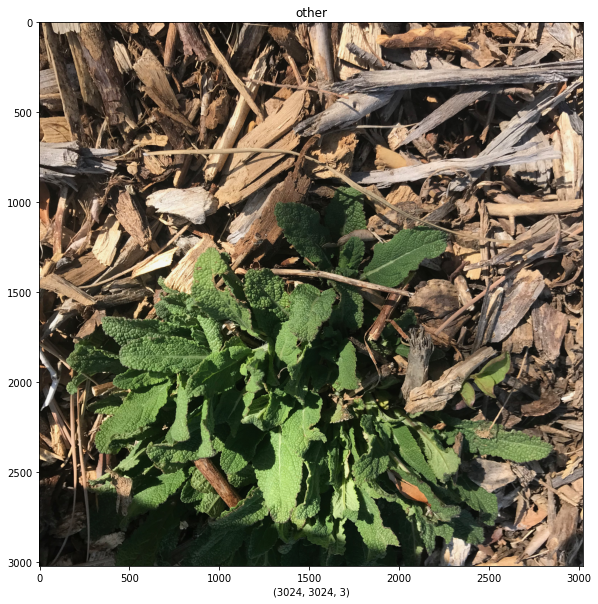

In [ ]:
figure = plt.figure(figsize=(10,10))
x = plt.imread(images_df["JPG"][2])
plt.imshow(x)
plt.xlabel(x.shape)
plt.title(images_df["CATEGORY"][2])

Text(0.5, 1.0, 'dandelion')

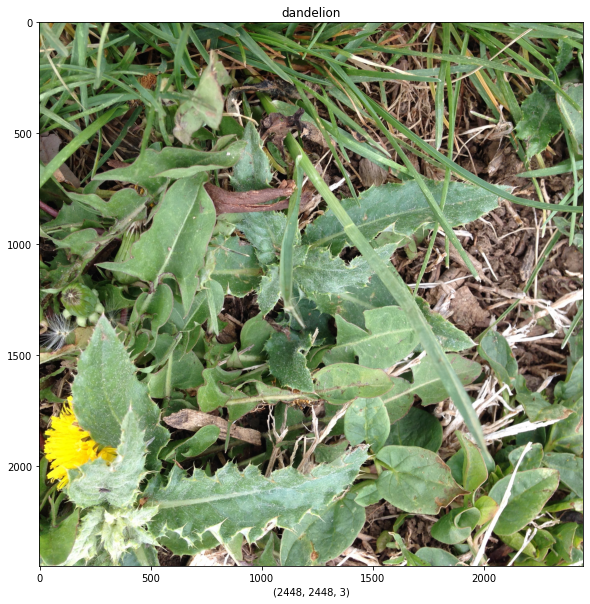

In [ ]:
figure = plt.figure(figsize=(10,10))
x = plt.imread(images_df["JPG"][1])
plt.imshow(x)
plt.xlabel(x.shape)
plt.title(images_df["CATEGORY"][1])

In [10]:
train, test = train_test_split(images_df,train_size=0.8,shuffle=True,random_state=10)

In [11]:
print('The size of the Train data is ', train.shape)
print('The size of the Test data is ', test.shape)

The size of the Train data is  (1009, 2)
The size of the Test data is  (253, 2)


In [12]:
Data_Generator = ImageDataGenerator(rescale=1./255,
                                   brightness_range=[0.3,0.7],
                                   width_shift_range=0.1,
                                   height_shift_range=0.1,
                                   zoom_range=0.1,
                                    vertical_flip=False,
                                    horizontal_flip=False,
                                    featurewise_std_normalization=False,
                                   validation_split=0.1)

In [13]:
train_Set = Data_Generator.flow_from_dataframe(dataframe=train,
                                              x_col="JPG",
                                              y_col="CATEGORY",
                                              # color_mode="grayscale",
                                              class_mode="binary",
                                              subset="training",
                                              batch_size=10,
                                              shuffle='True',
                                              target_size=(256,256))

validation_Set = Data_Generator.flow_from_dataframe(dataframe=train,
                                              x_col="JPG",
                                              y_col="CATEGORY",
                                              # color_mode="grayscale",
                                              class_mode="binary",
                                              subset="validation",
                                              batch_size=10,
                                              shuffle='True',
                                              target_size=(256,256))

Found 909 validated image filenames belonging to 2 classes.
Found 100 validated image filenames belonging to 2 classes.


In [14]:
test_Set = Data_Generator.flow_from_dataframe(dataframe=test,
                                              x_col="JPG",
                                              y_col="CATEGORY",                           
                                              class_mode="binary",
                                              batch_size=10,
                                              shuffle='True',
                                              target_size=(256,256))

Found 253 validated image filenames belonging to 2 classes.


In [ ]:
for data_batch,label_batch in train_Set:
    print("DATA SHAPE: ",data_batch.shape)
    print("LABEL SHAPE: ",label_batch.shape)
    break

DATA SHAPE:  (10, 256, 256, 3)
LABEL SHAPE:  (10,)


In [ ]:
for data_batch,label_batch in validation_Set:
    print("DATA SHAPE: ",data_batch.shape)
    print("LABEL SHAPE: ",label_batch.shape)
    break

DATA SHAPE:  (10, 256, 256, 3)
LABEL SHAPE:  (10,)


In [ ]:
for data_batch,label_batch in test_Set:
    print("DATA SHAPE: ",data_batch.shape)
    print("LABEL SHAPE: ",label_batch.shape)
    break

DATA SHAPE:  (10, 256, 256, 3)
LABEL SHAPE:  (10,)


In [15]:
base_model = ResNet50(include_top = False,
                  input_shape = (256,256,3),
                  weights = 'imagenet')

base_model.summary()

94773248/94765736 [==============================] - 1s 0us/step
Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 262, 262, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 128, 128, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 128, 128, 64) 256         conv1_conv[0][0]                 
__________________________

In [16]:
last_output=base_model.output

x = Flatten()(last_output)
x = Dense(1024, activation='relu')(x)
x = Dropout(0.5)(x)                  
x = Dense  (1, activation='sigmoid')(x) 

model = Model( base_model.input, x)

In [17]:
model.compile(loss='binary_crossentropy',
              optimizer=Adam(learning_rate=0.001),
              metrics=['accuracy'])

In [18]:
history = model.fit(
      train_Set,
      epochs=30,
      verbose=1,
      validation_data = validation_Set)

Epoch 1/30
91/91 [==============================] - 1257s 14s/step - loss: 10.9874 - accuracy: 0.5754 - val_loss: 13.7009 - val_accuracy: 0.4800
Epoch 2/30
91/91 [==============================] - 149s 2s/step - loss: 1.7644 - accuracy: 0.6491 - val_loss: 0.9289 - val_accuracy: 0.5200
Epoch 3/30
91/91 [==============================] - 148s 2s/step - loss: 0.8500 - accuracy: 0.6425 - val_loss: 0.6915 - val_accuracy: 0.5100
Epoch 4/30
91/91 [==============================] - 149s 2s/step - loss: 0.6416 - accuracy: 0.7085 - val_loss: 0.7022 - val_accuracy: 0.4800
Epoch 5/30
91/91 [==============================] - 149s 2s/step - loss: 0.5492 - accuracy: 0.6986 - val_loss: 0.7028 - val_accuracy: 0.4700
Epoch 6/30
91/91 [==============================] - 148s 2s/step - loss: 0.5260 - accuracy: 0.7195 - val_loss: 0.7739 - val_accuracy: 0.5000
Epoch 7/30
91/91 [==============================] - 148s 2s/step - loss: 0.5242 - accuracy: 0.6997 - val_loss: 0.6958 - val_accuracy: 0.5200
Epoch 8/3

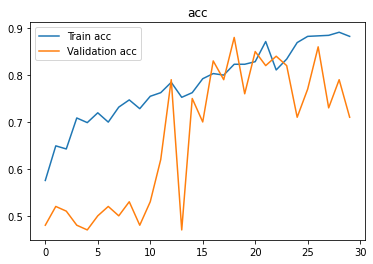

In [19]:
plt.title('acc')
plt.plot(history.epoch, history.history["accuracy"], label="Train acc")
plt.plot(history.epoch, history.history["val_accuracy"], label="Validation acc")
plt.legend()
plt.legend()

In [20]:
print("Validation Accuracy: " + str(history.history['val_accuracy'][-1:]))

Validation Accuracy: [0.7099999785423279]


In [34]:

%cd /content/drive//MyDrive/dandelionimagesdataset

/content/drive/MyDrive/dandelionimagesdataset


In [35]:
!pwd

/content/drive/My Drive/dandelionimagesdataset


In [36]:
from keras.models import load_model
model.save("model.h5")

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


In [38]:
my_model=tf.keras.models.load_model("/content/drive/MyDrive/dandelionimagesdataset/model.h5")

In [23]:
acc = my_model.evaluate(test_Set)
print('Test Accuracy is ',acc[1])

26/26 [==============================] - 304s 12s/step - loss: 1.3888 - accuracy: 0.6996
Test Accuracy is  0.6996047496795654


In [24]:
Model_Test_Pred = my_model.predict(test_Set)

In [33]:
import numpy as np
from google.colab import files
from keras.preprocessing import image

uploaded = files.upload()

for fn in uploaded.keys():
 
  # predicting images
  img = image.load_img(fn, target_size=(256, 256))
  x = image.img_to_array(img)
  x = np.expand_dims(x, axis=0)

  images = np.vstack([x])
  output = my_model.predict(images)
  if output[0] > 0.5:
    print(fn + " is Dandelion")
  else:
    print(fn + " is Grass")

Saving IMG_1118.jpg to IMG_1118.jpg
IMG_1118.jpg is Grass
